In [1]:
#Graph Dists
from graph_distances.competing_methods import getEVdist, getDegreedist, getG2V_dist, getNodeEmbeddingdist, getGOT
from our_external_pypi_package.prob_OT import getOT,cnp#,indicator_matrix_from_colors

#Benchmark
from benchmark import knn
import time

#Plotting
from tools.plotting import plot_heatmap, hier_clustering, plot_emb
import seaborn as sns
import matplotlib.pyplot as plt

#External Packages
import networkx as nx
import numpy as np
import pandas as pd
import random



from sklearn.mixture import GaussianMixture
#from klgmr import mixture_reduction
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from scipy.spatial.distance import pdist, cdist
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from numpy.linalg import inv
import umap
import pandas as pd
from sklearn.manifold import TSNE
from sklearn import manifold

from pydiffmap import diffusion_map


from scipy.spatial.distance import squareform
from matplotlib.patches import Patch
import pathlib

import random

%load_ext autoreload
%autoreload 2

/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument

In [2]:
def name2label(name):
    if "CK159" in name or "CK366" in name: # or "CK368" in name:
        return "Myogenic"  #"Young Fibrotic"
    if "IZ" in name:
        return "Ischemic"
    #elif "BZ" in name:
    #    return "Border"
    elif "FZ" in name:
        return "Fibrotic"
    elif "RZ" in name:
        return "Myogenic"
    elif "control" in name:
        return "Myogenic"
    else:
        return "Unknown"
    
label_order= ["Myogenic","Ischemic","Fibrotic"]

In [3]:
#path = pathlib.Path("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc2sc/100knn") #_gaussian_kernel") #full_npy") #
path_graph = pathlib.Path("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs")
path_feat = pathlib.Path("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature")
annotation_image_path = "/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA_corrected_labels/histoslides/"
annotation_niches_path = "/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA_corrected_labels/nicheslides/"

graphs = []
features = []
labels = []
patient_ids = []
annotation_image_paths = []
annotation_niches_paths = []

#for patient_folder in pathlib.Path(path).iterdir():
for sample, feats in zip(sorted(pathlib.Path(path_graph).iterdir()),sorted(pathlib.Path(path_feat).iterdir())):
    print(sample)
    print(feats)


    if "npy" in str(sample.suffix) :
        graph = np.load(sample)
        #graph = nx.from_numpy_array(arr)
    elif "csv" in str(sample.suffix) :
        df = pd.read_csv(sample,index_col=0)
        graph = nx.from_pandas_adjacency(df)
    else:
        continue 

    graphs.append(graph)
    features.append(np.load(feats))
    labels.append(name2label(str(sample.stem)))
    patient_ids.append(str(sample.stem)[:5])
    annotation_image_paths.append(annotation_image_path+"VIS"+str(sample.stem)[2:5]+".jpg")
    annotation_niches_paths.append(annotation_niches_path+"VIS"+str(sample.stem)[2:5]+".png")


/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK158_control_P1_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK158_control_P1_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK159_RZ_FZ_P5_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK159_RZ_FZ_P5_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK160_RZ_BZ_P3_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK160_RZ_BZ_P3_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK163_RZ_BZ_P2_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK163_RZ_BZ_P2_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_le

In [4]:
threshold = False

if threshold:

    threshold_cells = 2000
    del_index = []

    for i,graph in enumerate(graphs):
        if len(graph) < threshold_cells:
            print(labels[i])
            print(i)
            del_index.append(i)

    graphs = np.delete(np.array(graphs,dtype=object),del_index).tolist()
    features = np.delete(np.array(features,dtype=object),del_index).tolist()
    labels = np.delete(np.array(labels,dtype=object),del_index).tolist()

In [5]:
balance = False

if balance:
    unique, inds, counts = np.unique(labels, return_counts=True, return_index=True)
    unique = [labels[index] for index in sorted(inds)]
    n = np.min(counts)
    old_graphs, old_labels, old_conds, old_phase = graphs,np.asarray(labels),np.asarray(cond),np.asarray(phase)
    graphs, labels, cond, phase= [],[],[],[]
    for label in unique:
        inds = np.nonzero(old_labels==label)[0]
        random.shuffle(inds)
        graphs.extend([old_graphs[i] for c,i in enumerate(inds) if c < n])
        labels.extend(old_labels[inds][:n])
        cond.extend(old_conds[inds][:n])
        phase.extend(old_phase[inds][:n])

len(graphs[0])

3429

In [6]:
def plot_table(df,tranpose=False):
    format_df = df
    #format_df.set_index('method',inplace=True)
    if tranpose:
        format_df = format_df.transpose()
    display(format_df)
    print(format_df.to_latex(index=True,
                  #formatters={"name": str.upper},
                  float_format="{:.2f}".format,
    ))

cells_n = {}

for label, graph in zip(labels,graphs):
    cells_n[label] = cells_n.get(label,[]) + [len(graph)]

print(cells_n)


cells_avg_std = {label: f"{np.average(ns):.1f}±{np.std(ns):.1f}" for label,ns in cells_n.items()}  
cells_min = {label: np.amin(ns) for label,ns in cells_n.items()}
cells_max = {label: np.amax(ns) for label,ns in cells_n.items()}

formated_dict = {"Mean±Std":list(cells_avg_std.values()),"Min": list(cells_min.values()),"Max": list(cells_max.values())}
print(formated_dict )
df = pd.DataFrame(formated_dict ,index=cells_avg_std.keys())
df = df.reindex(["Myogenic","Control","Ischemic","Fibrotic"])
print(df)

{'Myogenic': [3429, 2910, 2621, 2785, 2819, 3210, 2804, 3143, 2825, 3743, 1817, 1872, 2638, 2744], 'Ischemic': [1585, 1013, 1393, 1009, 1393], 'Fibrotic': [1547, 1755, 945]}
{'Mean±Std': ['2811.4±497.9', '1278.6±229.5', '1415.7±343.5'], 'Min': [1817, 1009, 945], 'Max': [3743, 1585, 1755]}
              Mean±Std     Min     Max
Myogenic  2811.4±497.9  1817.0  3743.0
Control            NaN     NaN     NaN
Ischemic  1278.6±229.5  1009.0  1585.0
Fibrotic  1415.7±343.5   945.0  1755.0


In [7]:
#Params for CNP and CBB
i = 100
k = 15
d = 6
D = 5

precomputed_dists = {}
plans = {}
times = {}
struct_cost = {}
feat_cost = {}

n_cpus = 30

path = "/home/kuehn/CNP_OT/cnp-ot/data/results/trajectory/" 
save_name = "coloc+scRNa_withFNGW_full" 

#Loading functs
def tri_to_flat(tri_matrix):
    n = tri_matrix.shape[0]
    list = tri_matrix[np.triu_indices(n)].flatten()
    return list

def flat_to_tri(list):
    n = int(0.5 * (np.sqrt(8 * len(list) + 1) -1)) #Solves len(flat)= N(N+1)/2 for N
    tri_matrix = np.zeros((n,n))
    ind = np.triu_indices(n)
    tri_matrix[ind] = np.array(list)
    return tri_matrix

load = True
if load:
    if True: #input(f"Currently loading is set to {load}, please confirm that you want to overwrite variables") =='':
        precomputed_dists =  np.load(path+save_name+"dists.npy",allow_pickle=True).tolist() 
        times =np.load(path+save_name+"times.npy",allow_pickle=True).tolist() 
        labels = np.load(path+save_name+"labels.npy",allow_pickle=True).tolist() 
        patient_ids = np.load(path+save_name+"patientid.npy",allow_pickle=True).tolist() 

save_name = "coloc+scRNa_FusedWasserstein_" 
print(precomputed_dists.keys())

dict_keys(['Degree', 'EV', 'Graph2Vec', 'Role2vec-GW', 'Node2Vec-GW', 'CCB-TiedW_a0.00', 'CCB-TiedW_a0.10', 'Role2vec-FGW', 'Node2Vec-FGW', 'CCB-TiedW_a0.20', 'CCB-TiedW_a0.30', 'CCB-TiedW_a0.50', 'CCB-TiedW_a1.00', 'CNP-TiedW_a0.00', 'CNP-TiedW_a0.50', 'CNP-TiedW_a1.00', 'CCB-TiedW_a0.40', 'CCB-TiedW_a0.60', 'CCB-TiedW_a0.70', 'CCB-TiedW_a0.80', 'CCB-TiedW_a0.90', 'CNP-TiedW_a0.10', 'CNP-TiedW_a0.20', 'CNP-TiedW_a0.30', 'FNGW_1/4CNP_1/4CCB_1/2RNA', 'FNGW_1/3CNP_CCB_RNA', 'FNGW_2/5CNP_2/5CCB_1/5RNA', 'FNGW_CNP', 'FNGW_CCB', 'FNGW_1/5CNP_1/5CCB_3/5RNA', 'FNGW_2/5CNP_1/5CCB_2/5RNA', 'FNGW_RNA'])


In [8]:
from FusedWasserstein import fw

cnp_emb = getOT(graphs,None,None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.0,num_workers=n_cpus,embedding_only=True )
ccb_emb = getOT(graphs,None,None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.0,num_workers=n_cpus,embedding_only=True )




DONE: 100%|██████████| 22/22 [07:51<00:00, 21.41s/it]


[[ 0.30312947  0.16584315  0.0562294 ]
 [ 0.37410133 -0.13008656 -0.02041889]
 [ 0.2677983   0.22229336  0.0539112 ]
 [ 0.38416186 -0.18683012 -0.03925253]
 [ 0.22572064  0.23509976  0.03013449]
 [ 0.38197776 -0.17359783 -0.03461966]
 [ 0.37247474 -0.12288244 -0.01843403]
 [ 0.29312478  0.19285838  0.06018028]
 [ 0.35765693 -0.04734602  0.00451411]
 [ 0.3800758  -0.16248075 -0.03080903]
 [-0.40131616  0.11779923 -0.30803872]
 [ 0.3701254  -0.1087231  -0.01362043]
 [ 0.32722416  0.08707972  0.04065724]
 [-0.58885208  0.00659231 -0.1008783 ]
 [ 0.27838812  0.21357424  0.05803814]
 [-0.64259498 -0.0490774   0.09321603]
 [-0.65858239 -0.06903689  0.17461329]
 [-0.6561771  -0.06578653  0.16054672]
 [-0.62192577 -0.02570247  0.00565548]
 [-0.63805499 -0.04346703  0.07066032]
 [ 0.3697996  -0.1072786  -0.01322989]
 [-0.50390364  0.07052582 -0.26472884]]
(22, 2)
ward


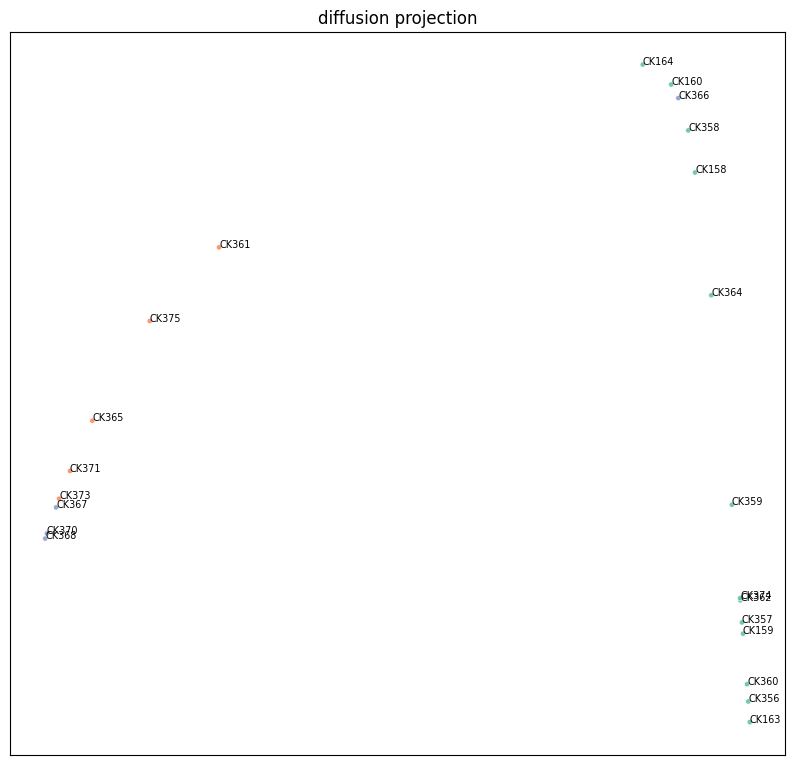

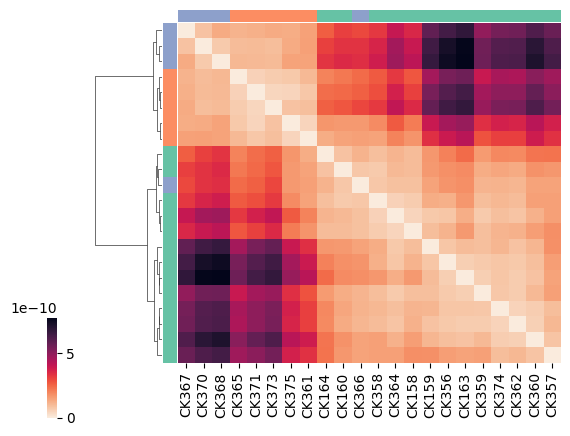

median


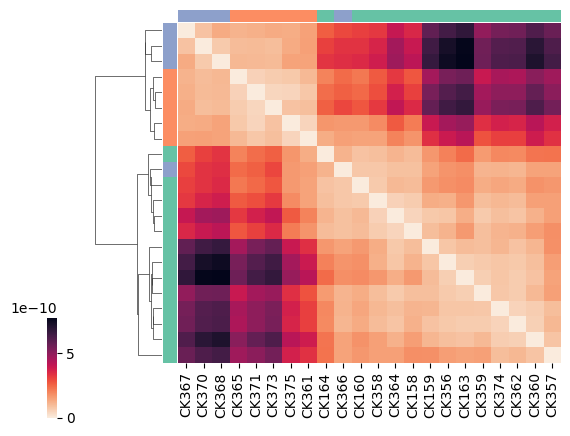

centroid


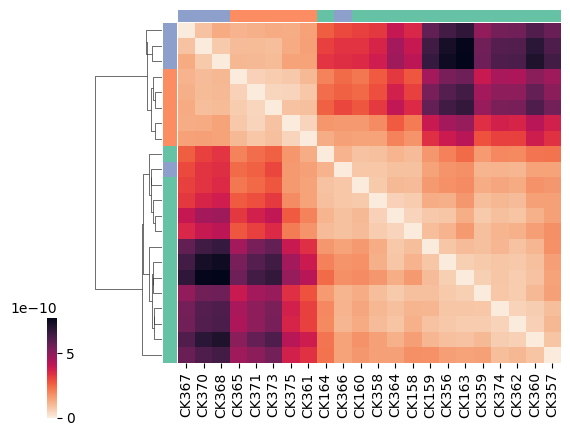

weighted


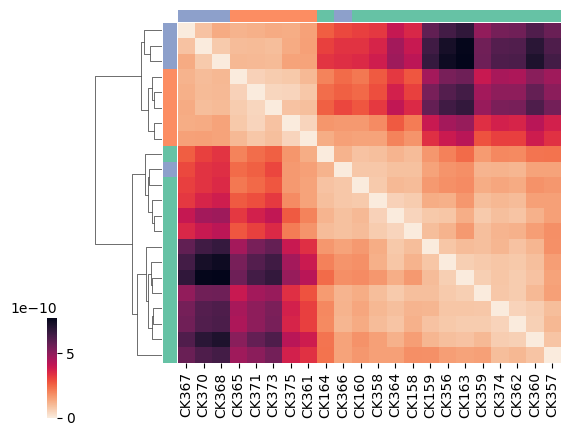

average


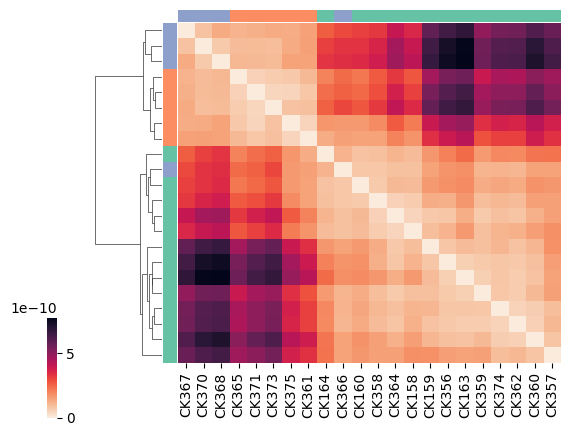

complete


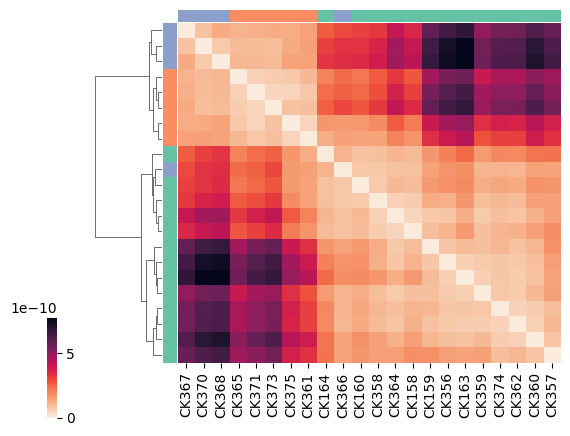

single


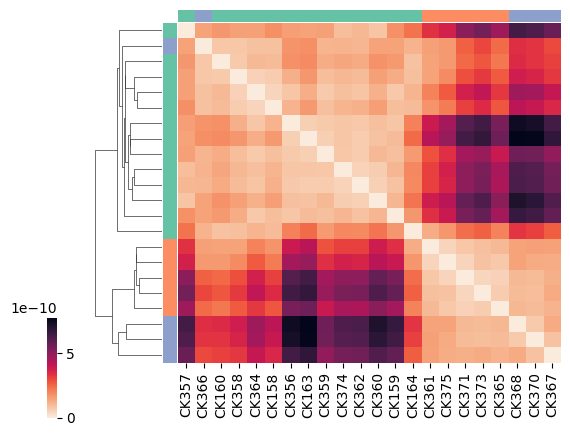

In [11]:

#dist  = fw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=False,threads=n_cpus,alpha=[1/3,1/3],beta=[1/3])

plot_emb(dist,method='diffusion',colors=labels,legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)

for linkage in ["ward","median","centroid","weighted","average","complete","single"]:

    print(linkage)
    hier_clustering(dist,labels, ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids,method=linkage)

In [ ]:
%load_ext autoreload
%autoreload 2
methods =  {
    #"FNGW_2/5CNP_2/5CCB_1/5RNA": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[2/5,2/5],beta=[1/5])),
    #"FNGW_1/5CNP_1/5CCB_3/5RNA": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1/5,1/5],beta=[3/5])),
    #"FNGW_2/5CNP_1/5CCB_2/5RNA": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[2/5,1/5],beta=[2/5])),
    "FNGW_CNP1": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1],beta=[0])),
    "FNGW_CNP_test": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1,0],beta=[0])),
    "FNGW_CCB1": (lambda G1,G2,feats: fngw(embeddings=[ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1],beta=[0])),
    "FNGW_CCB1_test": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[0,1],beta=[0])),
    "FNGW_RNA": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[0,0],beta=[1])),

    "FNGW_1/4CNP_1/4CCB_1/2RNA_test": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus)),
    "FNGW_1/3CNP_CCB_RNA_test": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1/3,1/3],beta=[1/3])),
    "FNGW_1/2CCB_RNA_test": (lambda G1,G2,feats: fngw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[0,1/2],beta=[1/2])),

    #Euclidean Dists
    #"Degree": (lambda G1,G2, feats: getDegreedist(G1,G2)),
    #"EV": (lambda G1,G2, feats: getEVdist(G1,G2)),
    #"Graph2Vec": (lambda G1,G2, feats: getG2V_dist(G1,G2, dim=(64 * k * d))),
    #"CCB-TiedW_a0 (genexp only)": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.,num_workers=n_cpus )),
    #"CCB-TiedW_a0.25": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.25,num_workers=n_cpus )),
    #"CCB-TiedW_a0.5": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus )),
    #"CCB-TiedW_a0.75": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.75,num_workers=n_cpus )),
    #"CCB-TiedW_a1 (spatial only)": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus )),
    
    
    #"CCB-TiedW2k2d": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i*2, k_colors=2*k, d_depth=2*d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus )),
    #"CCB-TiedW4k2d": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i*4, k_colors=2*k, d_depth=2*d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus )),

    #Gromov-Wasserstein Dists
    #"Node2Vec-GW":(lambda G1,G2, feats: getNodeEmbeddingdist(G1, G2, embedding_name='node2vec', D_dimensions=(k * d),distance='gw')),
    "Role2vec-FGW_RNA":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0,num_workers=n_cpus,embedding_method="role2vec",distance='fgw')),
    "Role2vec-FGW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,embedding_method="role2vec",distance='fgw')),
    "Role2vec-GW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="role2vec",distance='gw')),
    "Node2Vec-FGW_RNA":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0,num_workers=n_cpus,embedding_method="node2vec",distance='fgw')),
    "Node2Vec-FGW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,embedding_method="node2vec",distance='fgw')),
    "Node2Vec-GW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="node2vec",distance='gw')),

    #Wasserstein Dists.
    #"GOT": (lambda G1,G2: getGOT(G1,G2,dist='GOT')),
    #"CNP-TiedW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None,num_workers=n_cpus )), 
    #"CCB-TiedW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus )),
    #"CNP-ScaledW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None,num_workers=n_cpus ,covariance='scaled')), 
    #"CCB-ScaledW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus ,covariance='scaled')),
    #"CNP-FullW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=20,num_workers=n_cpus ,covariance='full')), 
    #"CCB-FullW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=20, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus ,covariance='full')),


    }



#methods.update({
#    f"CCB-TiedW_a{a:.2f}": (lambda G1,G2, feats,alpha=a: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=alpha,num_workers=n_cpus,scale_multiple_costs="mean_dist" )) for a in np.linspace(0,1,num=3)    
#})

#methods.update({
#    f"CNP-TiedW_a{a:.2f}": (lambda G1,G2, feats,alpha=a: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=alpha,num_workers=n_cpus,scale_multiple_costs="mean_dist" )) for a in np.linspace(0,1,num=3)
#})




#These two are not equivalent, fuck meee
test = {f"{a:.2f}": lambda : print(a) for a in np.linspace(0,1,num=3)}
for a in test:
    test[a]()

test = {f"{a:.2f}": lambda alpha=a: print(alpha) for a in np.linspace(0,1,num=3)}
for a in test:
    test[a]()

'''
methods= {
    "CNP-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus )),   
    "CCB-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus )),

    "CNP-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean")),   
    "CCB-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean" )),

    "CNP-TiedW_a0.5_emb_norm": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="norm")),   
    "CCB-TiedW_a0.5_emb_norm": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="norm" )),
}
'''

    
#methods= {
#    f"CCB-TiedW_a{alpha:.2f}": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=alpha,num_workers=n_cpus )) for alpha in np.linspace(0,1,num=11),   
#    f"CNP-TiedW_a{alpha:.2f}": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=alpha,num_workers=n_cpus )) for alpha in np.linspace(0,1,num=11),   
#}

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    if self.autoload_obj:
        ^^^^^^^^^^^^^^^^^^
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    except (TypeError, AttributeError, KeyError):
                 ^^^^^^^^^^^^^^
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
                             ^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/IPython/extensions/autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0
1.0
1.0
0.0
0.5
1.0


'\nmethods= {\n    "CNP-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus )),   \n    "CCB-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus )),\n\n    "CNP-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean")),   \n    "CCB-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean" )),\n\n    "CNP-TiedW_a0.5_emb_norm": (lambda G1,G2, 

--- Logging error ---
Traceback (most recent call last):
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
    await result
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 753, in execute_request
    self.log.debug("%s", reply_msg)
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/logging/__init__.py", line 1477, in debug
    self._log(DEBUG, msg, args, **kwargs)
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/logging/__init__.py", line 1632, in _log
    record = self.makeRecord(self.name, level, fn, lno, msg, args,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/logging/__init__.py", line 1601, in makeRecord
    rv = _logRecordFactory(name, level, fn, lno, msg, args, exc_info, func,
         ^^^^^^^^^^^^^^^^^^^^^^

: 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 5
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


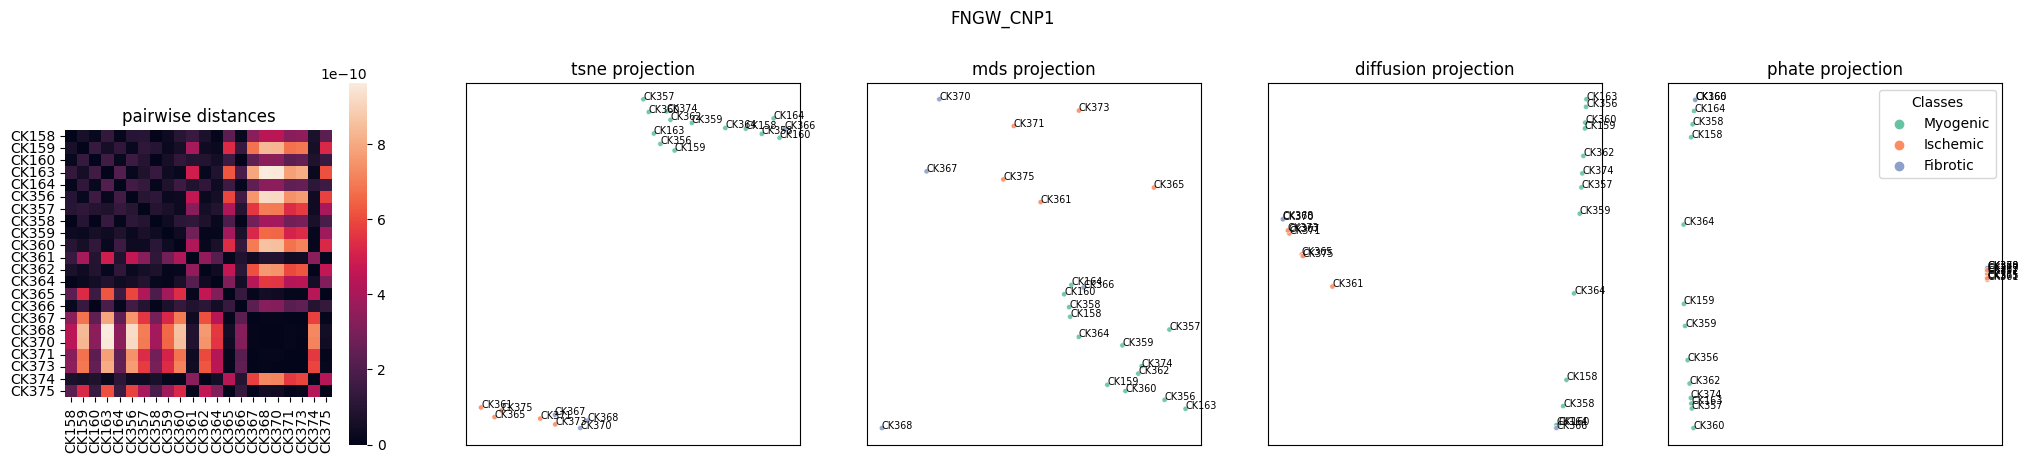

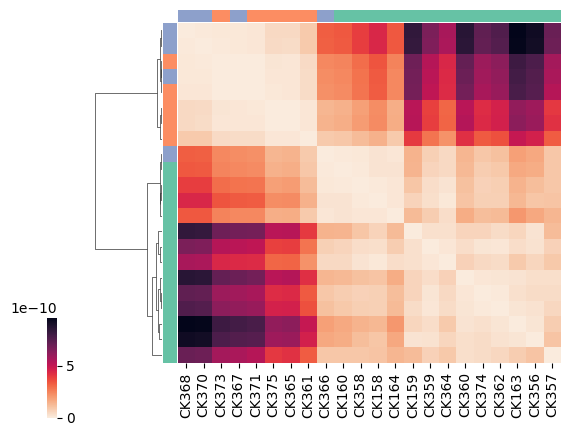

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 5
  Calculating diffusion potential...
  Calculating metric MDS...


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


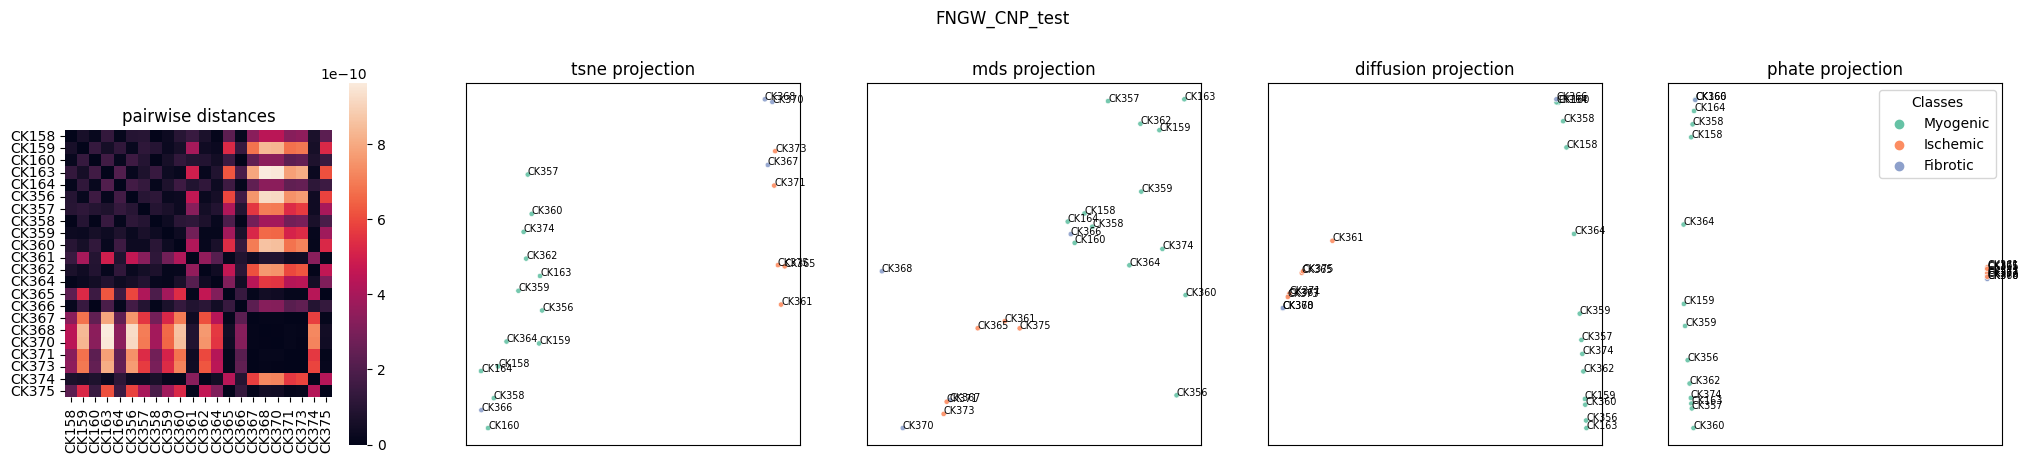

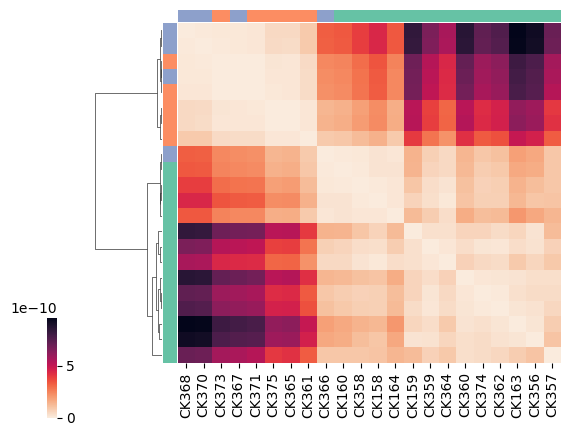

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 33
  Calculating diffusion potential...
  Calculating metric MDS...


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


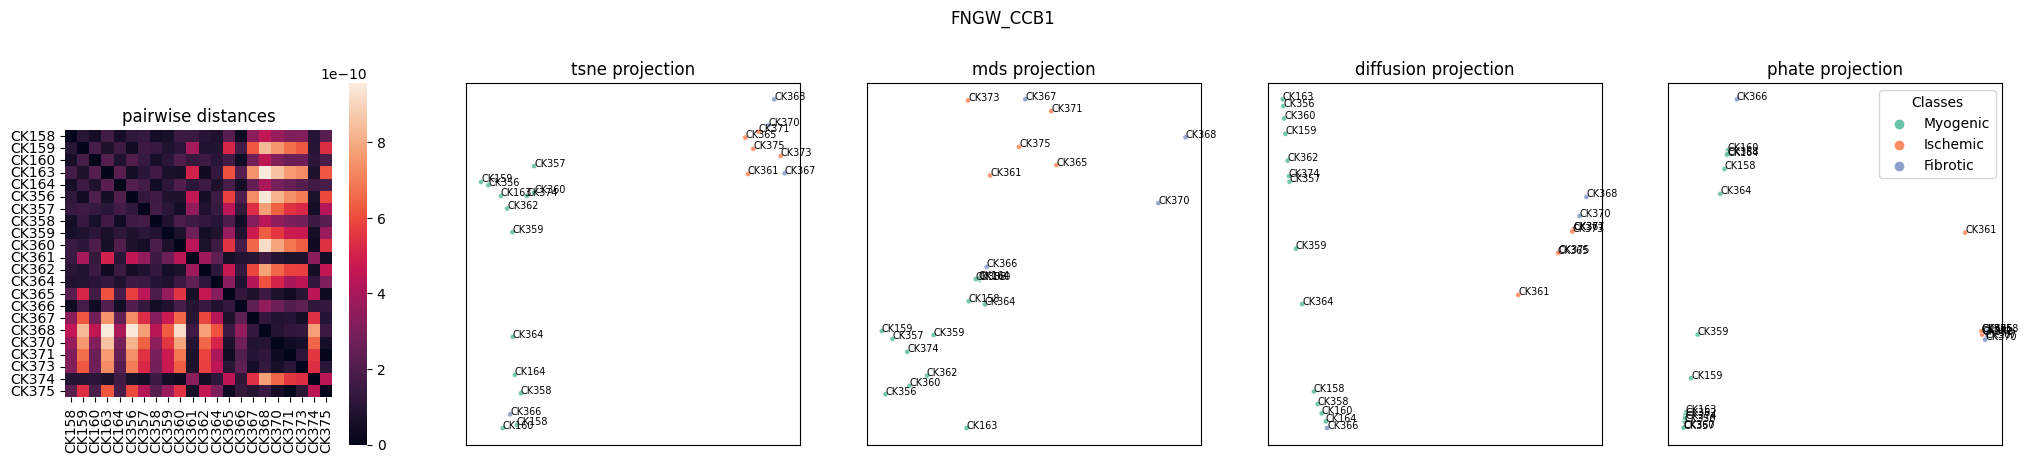

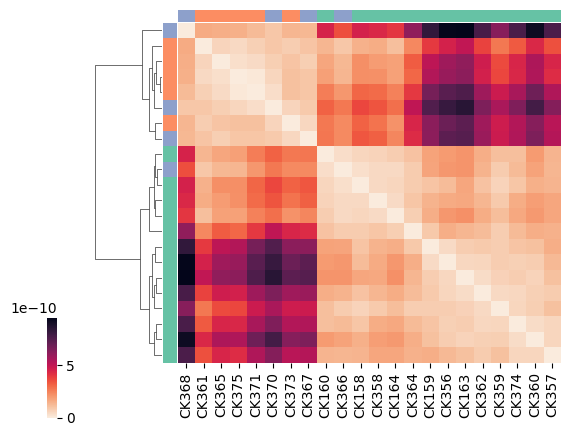

Precomputing Node Distances between Graphs in respective Structural and Feature Spaces:


DONE: 100%|██████████| 231/231 [03:35<00:00,  1.07it/s]

Computing FNGW between all Graph Pairs



DONE: 100%|██████████| 231/231 [04:05<00:00,  1.06s/it]


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 33
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.01 seconds.


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


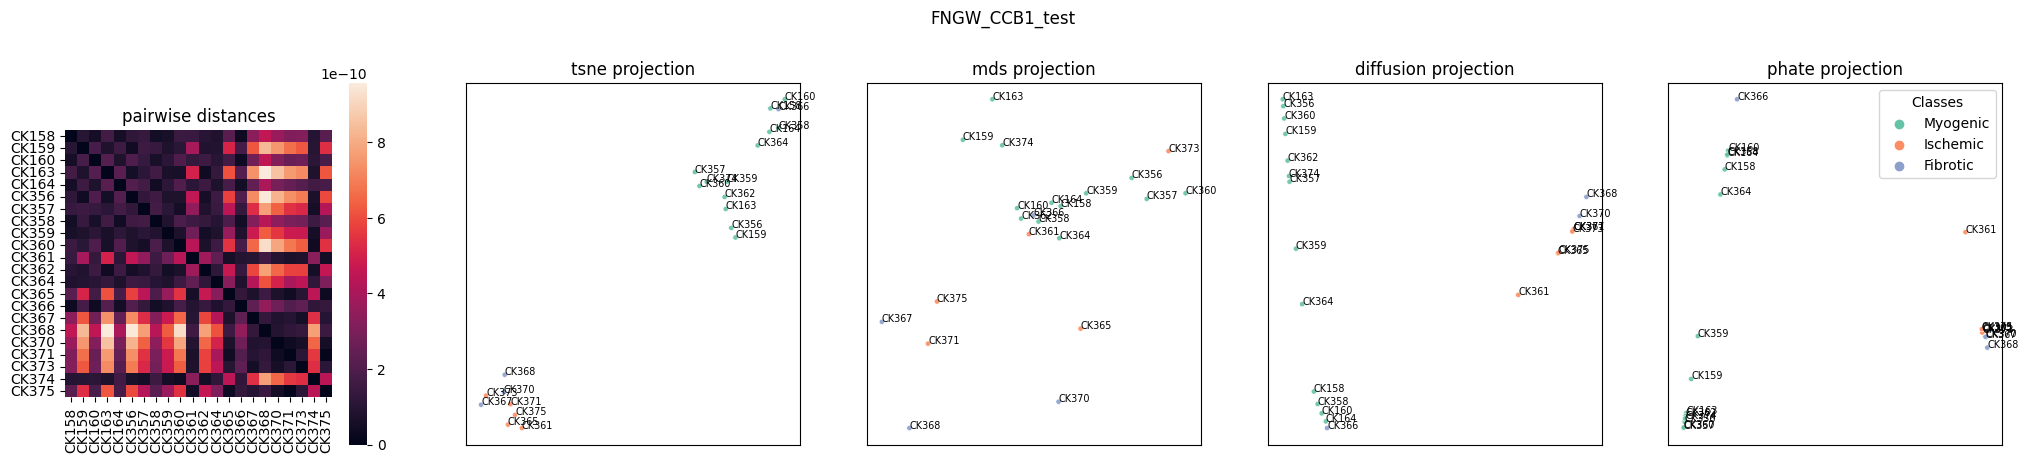

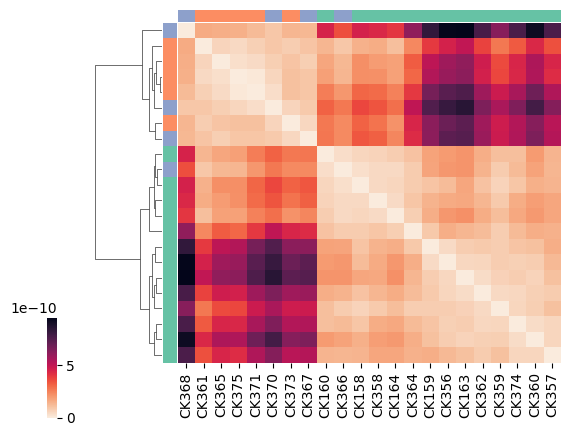

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 7
  Calculating diffusion potential...
  Calculating metric MDS...


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


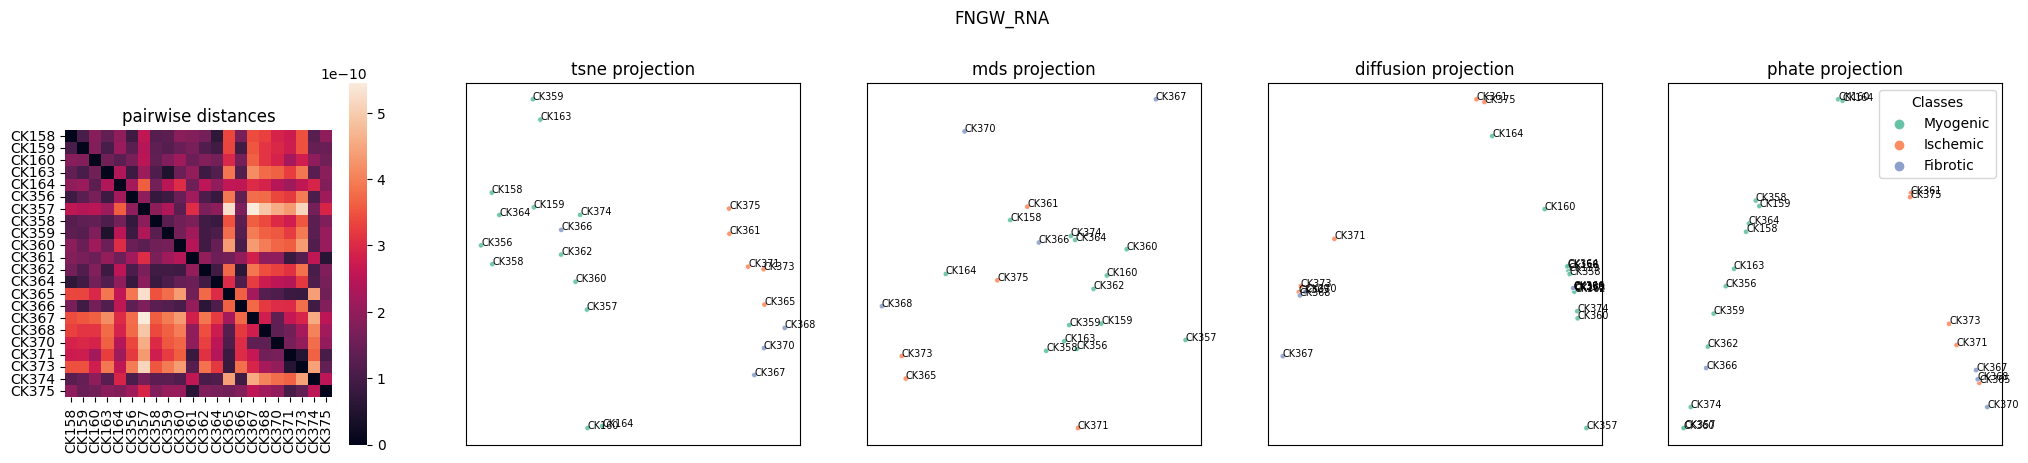

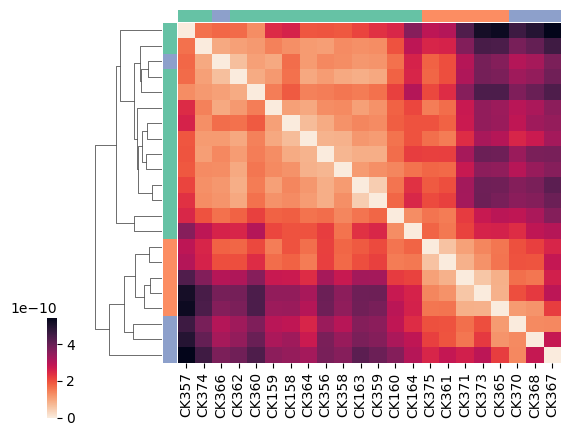

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 12
  Calculating diffusion potential...
  Calculating metric MDS...


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


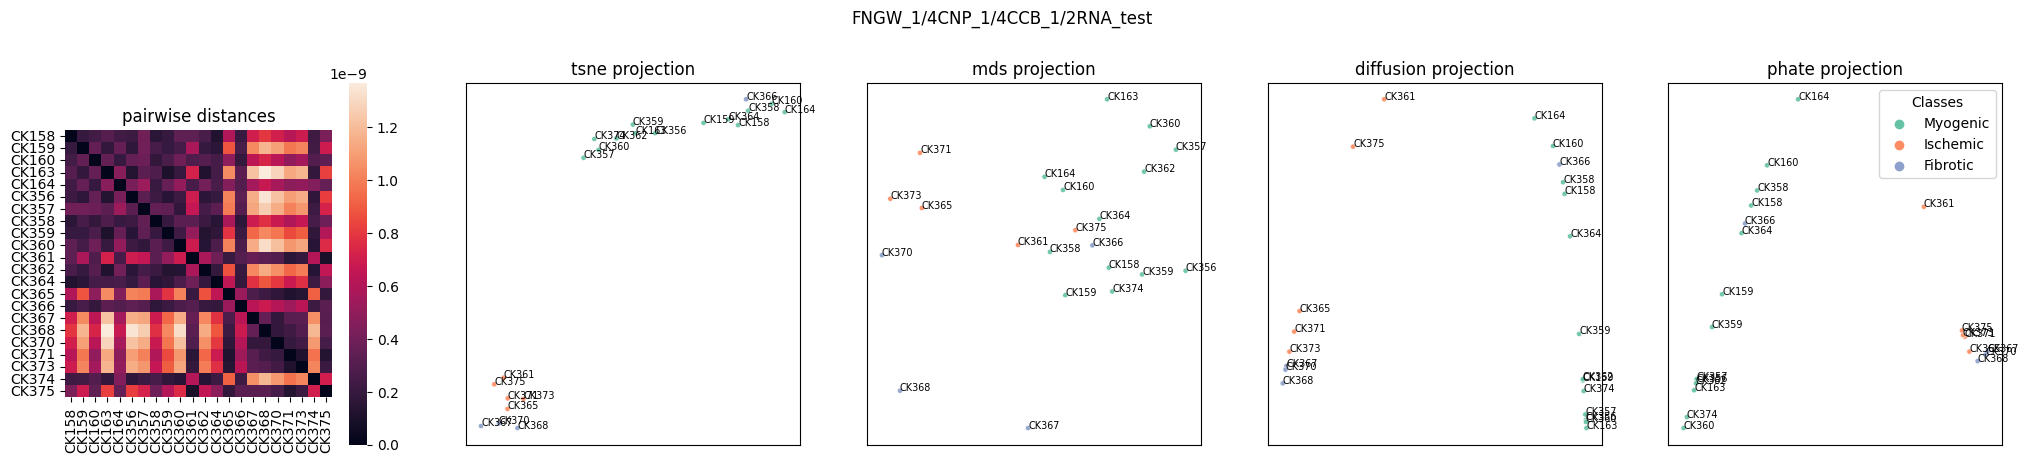

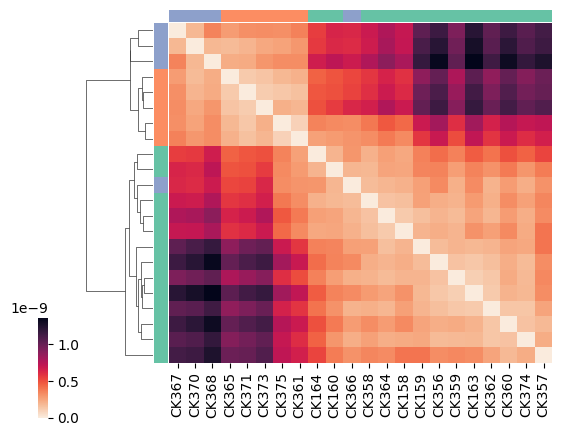

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 23
  Calculating diffusion potential...
  Calculating metric MDS...


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


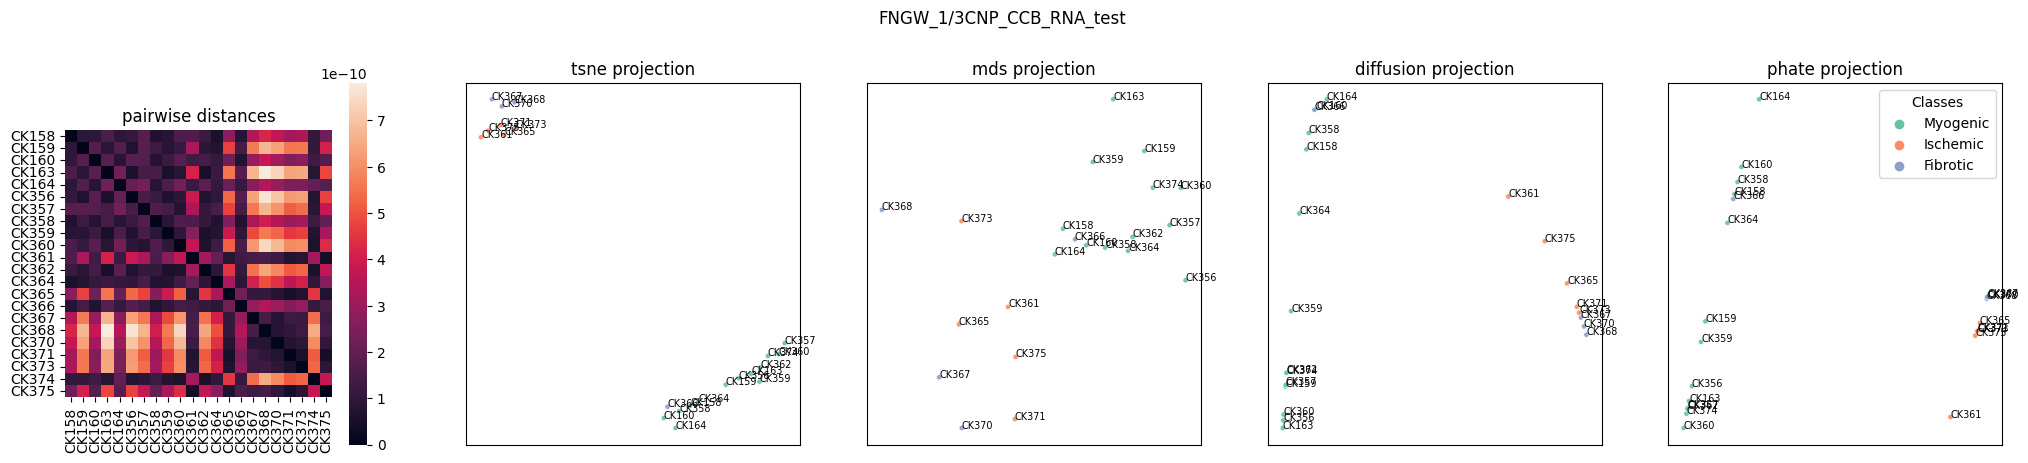

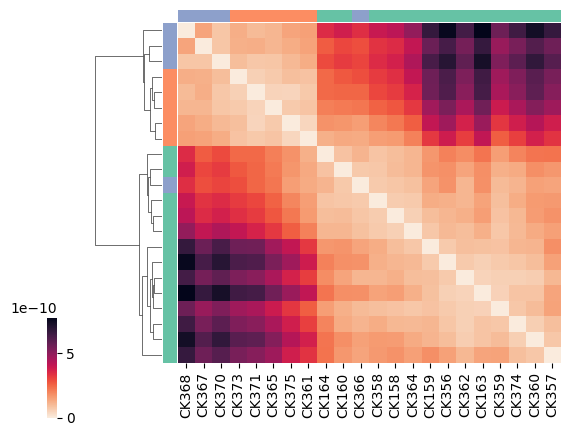

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 22 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 14
  Calculating diffusion potential...
  Calculating metric MDS...


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


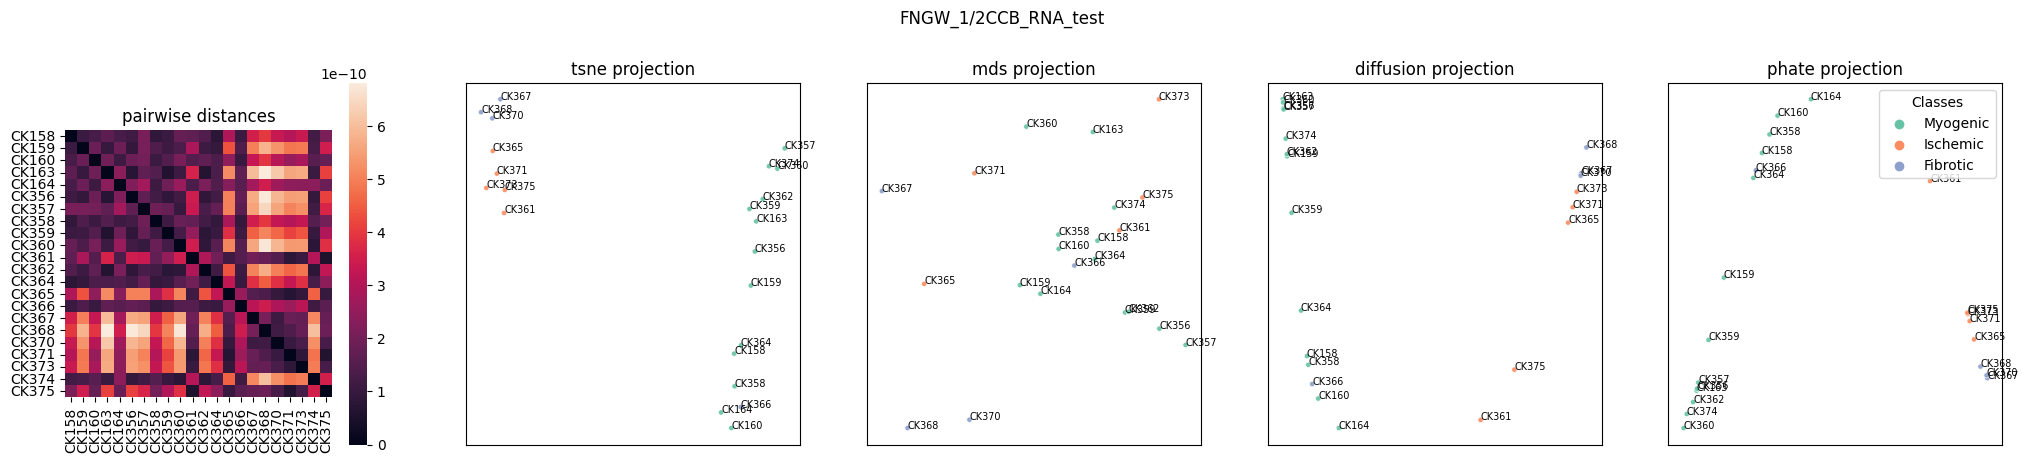

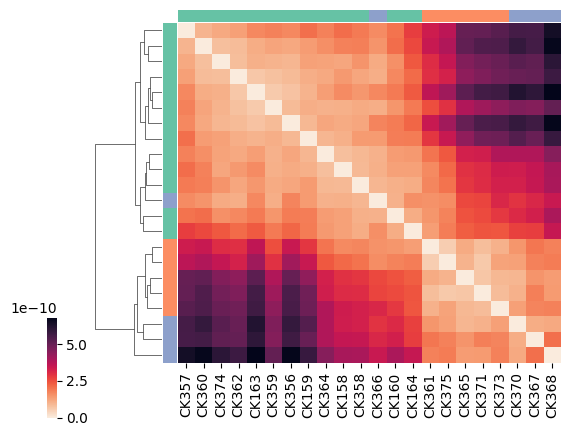

In [ ]:
import time
%load_ext autoreload
%autoreload 2
#Precompute Distances


time_limit = 10
for method, func in methods.items():
    if times.get(method, 0) < time_limit:
        st = time.time()
        precomputed_dists[method], plans[method],struct_cost[method], feat_cost[method] = func(graphs,None,features)
        et = time.time()
        times[method] = et - st
        precomputed_dists[method][precomputed_dists[method]<0] = 0

    fig, axs = plt.subplots(1,5,figsize=(25,5))
    plot_heatmap(precomputed_dists[method],patient_ids,ax=axs[0])
    plot_emb(precomputed_dists[method],method='tsne',colors=labels,ax=axs[1],legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    plot_emb(precomputed_dists[method],method='mds',colors=labels,ax=axs[2],legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    plot_emb(precomputed_dists[method],method='diffusion',colors=labels,ax=axs[3],legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    plot_emb(precomputed_dists[method],method='phate',colors=labels,ax=axs[4],legend=True,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    fig.suptitle(method)

    hier_clustering(precomputed_dists[method],labels, ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    plt.show()


In [ ]:
#path = "/home/kuehn/CNP_OT/cnp-ot/data/results/trajectory/" 
#" #+datetime.now().strftime("%H:%M:%S")
save_name = "coloc+scRNa_withFNGW_clean" 

precomputed_dists_old = precomputed_dists
precomputed_dists = {key: precomputed_dists_old[key] for key in methods.keys()}

times_old = times
times = {key: times_old [key] for key in methods.keys()}


def tri_to_flat(tri_matrix):
    n = tri_matrix.shape[0]
    list = tri_matrix[np.triu_indices(n)].flatten()
    return list
    

def flat_to_tri(list):
    n = int(0.5 * (np.sqrt(8 * len(list) + 1) -1)) #Solves len(flat)= N(N+1)/2 for N
    tri_matrix = np.zeros((n,n))
    ind = np.triu_indices(n)
    tri_matrix[ind] = np.array(list)
    return tri_matrix


if False:
    method_name = f"CCB-TiedW_a0.5"
    np.savez(path+name+"graph_dists.npz",precomputed_dists[method_name])
    np.savez_compressed(path+name+"transport_plans.npz",tri_to_flat(plans[method_name])) 
    np.savez_compressed(path+name+"struct_cost.npz",tri_to_flat(struct_cost[method_name])) 
    np.savez_compressed(path+name+"feat_cost.npz",tri_to_flat(feat_cost[method_name]))

save=True
save_name = save_name+"temp"
if save:
    if True: #input(f"Currently saving is set to {save}, please confirm that you want to overwrite disk") =='':
        np.save(path+save_name+"dists.npy",precomputed_dists)
        np.save(path+save_name+"times.npy",times) 
        np.save(path+save_name+"labels.npy",labels)
        np.save(path+save_name+"patientid.npy",patient_ids)

    # = np.load(path+name+"dists.npy",allow_pickle=True).tolist()
    #times = np.load(path+name+"times.npy",allow_pickle=True).tolist()



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier


def KNN_from_dists(Graphs, labels, precomputed_dists=None, n_splits=20, method="TiedOT",n_neighbors=3,weights=None,test_size=0.1):
    predicted_labels, true_labels, scores, ari = [],[],[],[]


    if n_splits>0:
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size,random_state=0)
        train_test_inds = sss.split(np.zeros(len(Graphs)), labels)
    else:
        #Train = Test
        train_test_inds = [(np.arange(len(Graphs)),np.arange(len(Graphs)))]  #, np.arange(len(Graphs)))

    for i, (train_index, test_index) in enumerate(train_test_inds):
        if precomputed_dists is None:
            train_dists = compute_dists([Graphs[t] for t in train_index],None,method=method)
            test_to_train_dists = compute_dists([Graphs[t] for t in test_index],[Graphs[t] for t in train_index],method=method)
        else:
            train_dists = get_dist_precomputed(precomputed_dists, train_index, train_index)
            test_to_train_dists = get_dist_precomputed(precomputed_dists, test_index, train_index)

        
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric="precomputed",weights=weights)
        neigh.fit(train_dists,[labels[t] for t in train_index])

        predicted_labels.append(neigh.predict(test_to_train_dists))
        true_labels.append(np.asarray([labels[t] for t in test_index]))
        scores.append(neigh.score(test_to_train_dists,true_labels[-1]))
        ari.append(adjusted_rand_score(predicted_labels[-1],true_labels[-1]))


    return predicted_labels, true_labels, scores, ari


def compute_dists(Graphs,Graphs2=None, method="TiedOT"):
    dist, plan = methods[method](Graphs,Graphs2)
    dist[dist<0] = 0
    return dist

def get_dist_precomputed(precomputed_dists, ind1, ind2):
    return precomputed_dists[ind1,:][:,ind2]

def plot_1split(predicted, true,title=None,ax=None):
    annot_labels_ind =np.unique(true,return_index=True)[1]
    annot_labels = true[annot_labels_ind]
    #ind
    cf_matrix = confusion_matrix(true, predicted, labels=annot_labels)
    if ax is None:
        plt.figure()
    ax = sns.heatmap(cf_matrix, annot=True, #fmt='.0', 
            cmap='Blues', xticklabels=annot_labels,yticklabels=annot_labels,ax=ax,fmt='g')
    ax.set(xlabel="Predicted Label", ylabel="True Label")
    ax.set_title(title)

def plot_table(df,tranpose=False):
    format_df = df
    format_df.set_index('method',inplace=True)
    if tranpose:
        format_df = format_df.transpose()
    display(format_df)
    print(format_df.to_latex(index=True,
                  #formatters={"name": str.upper},
                  float_format="{:.2f}".format,
    ))
    

KNN T=0.75    SC   ARI       Time
method                                                     
FNGW_1/4CNP_1/4CCB_1/2RNA  0.87±0.07  .430  0.77    1337.95
FNGW_CNP                   0.81±0.11  .509  0.64    2013.02
FNGW_CCB                   0.87±0.11  .482  0.74    1617.53
FNGW_RNA                   0.85±0.10  .336  0.68    2144.32
Role2vec-FGW_RNA           0.85±0.10  .335  0.68    3169.37
Role2vec-FGW               0.85±0.10  .335  0.68    3999.65
Role2vec-GW                0.77±0.10  .351  0.54   15068.57
Node2Vec-FGW_RNA           0.85±0.10  .335  0.68   11327.27
Node2Vec-FGW               0.85±0.10  .335  0.68   12487.99
Node2Vec-GW                0.70±0.12  .252  0.52   22108.91

\begin{tabular}{lllll}
\toprule
 & KNN T=0.75 & SC & ARI & Time \\
method &  &  &  &  \\
\midrule
FNGW_1/4CNP_1/4CCB_1/2RNA & 0.87±0.07 & .430 & 0.77 &  1337.95 \\
FNGW_CNP & 0.81±0.11 & .509 & 0.64 &  2013.02 \\
FNGW_CCB & 0.87±0.11 & .482 & 0.74 &  1617.53 \\
FNGW_RNA & 0.85±0.10 & .336 & 0.68 &  2144.32 \\
Role2vec-FGW_RNA & 0.85±0.10 & .335 & 0.68 &  3169.37 \\
Role2vec-FGW & 0.85±0.10 & .335 & 0.68 &  3999.65 \\
Role2vec-GW & 0.77±0.10 & .351 & 0.54 &  15068.57 \\
Node2Vec-FGW_RNA & 0.85±0.10 & .335 & 0.68 &  11327.27 \\
Node2Vec-FGW & 0.85±0.10 & .335 & 0.68 &  12487.99 \\
Node2Vec-GW & 0.70±0.12 & .252 & 0.52 &  22108.91 \\
\bottomrule
\end{tabular}



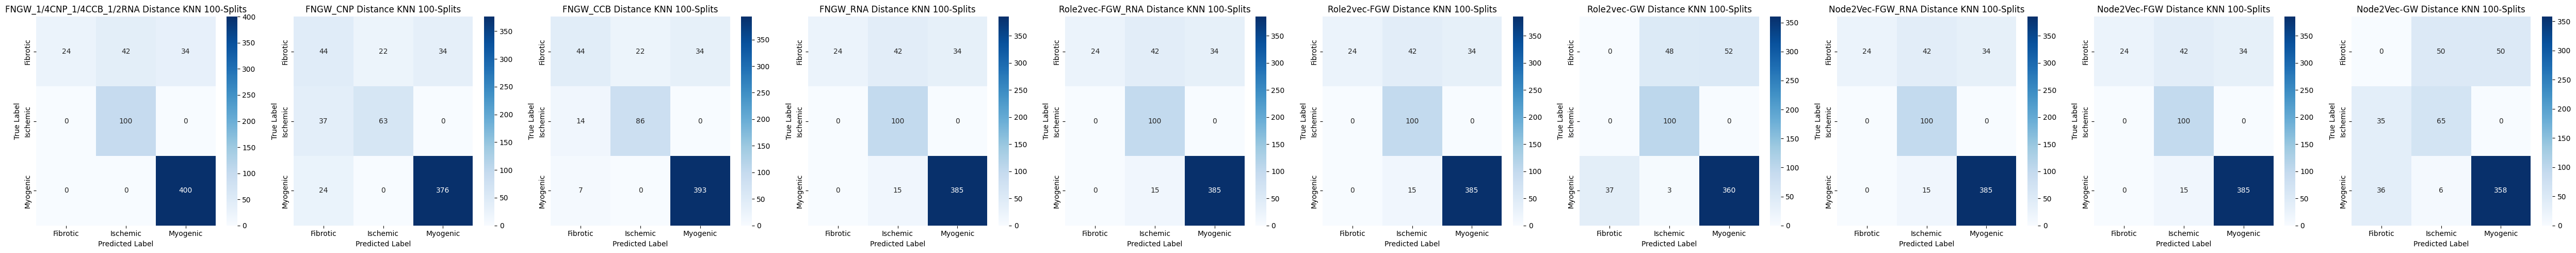

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

# Weighted
#KNN over precomputed distances
fig, axs = plt.subplots(1,len(methods.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)



results = {"method":[],
           "KNN T=0.75":[],
           #"KNN T=0.1":[],
           "SC":[],
           "ARI":[],
           "Time":[]}

#for m, (method, dist) in enumerate(precomputed_dists.items()):
for m, (method, func) in enumerate(methods.items()):
    dist = precomputed_dists[method]
    pred, true, score, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.25,n_splits=100)
    #for i,(p,t) in enumerate(zip(pred,true)):
    plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])

    #pred2, true2, score2, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.9)
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred2),np.concatenate(true2),title=f"{method} Distance KNN {len(pred2)}-Splits",ax=axs[1,m])

    zero_dia_dists = precomputed_dists[method]
    np.fill_diagonal(zero_dia_dists,0)
    sil = silhouette_score(zero_dia_dists,labels,metric="precomputed")

    ari = adjusted_rand_score(np.concatenate(true),np.concatenate(pred))
    
    #plt.show()
    results["method"].append(method)
    #results["Classification Score"].append(np.average(score))
    results["KNN T=0.75"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    #results["KNN T=0.1"].append(f"{np.average(score2):.2f}±{np.std(score2):.2f}")
    results["ARI"].append(f"{np.average(ari):.2f}")
    results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    results["Time"].append(f"{times[method]/(len(graphs)*(len(graphs)-1)/2) * 1000: .2f}")

fig.tight_layout()
plot_table(pd.DataFrame(results))






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FNGW_1_4CNP_1_4CCB_1_2RNA
/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial/FNGW_1_4CNP_1_4CCB_1_2RNA_mds_projection.png


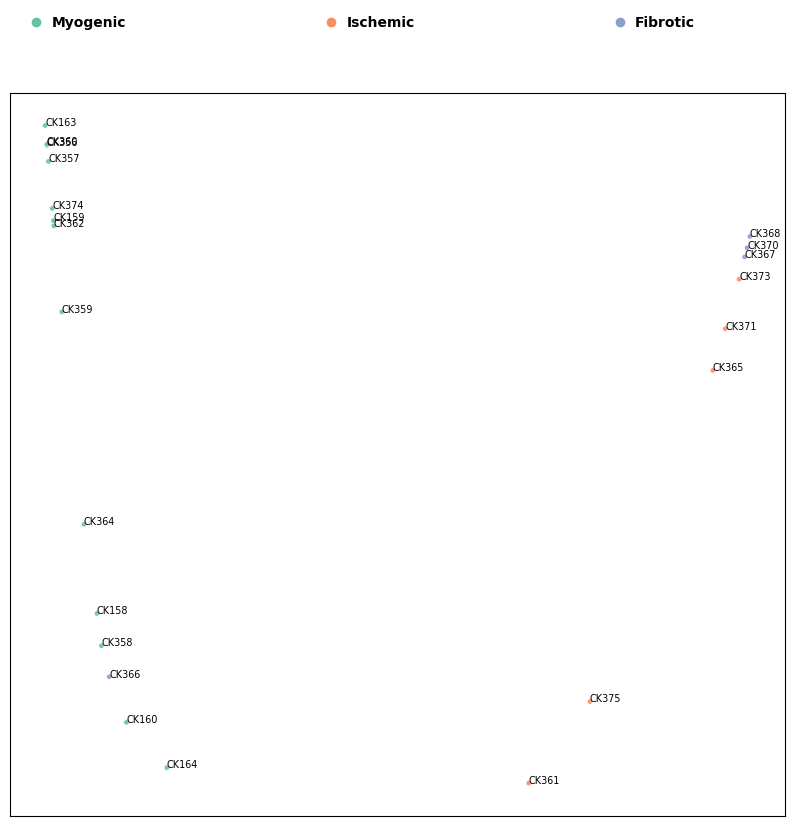

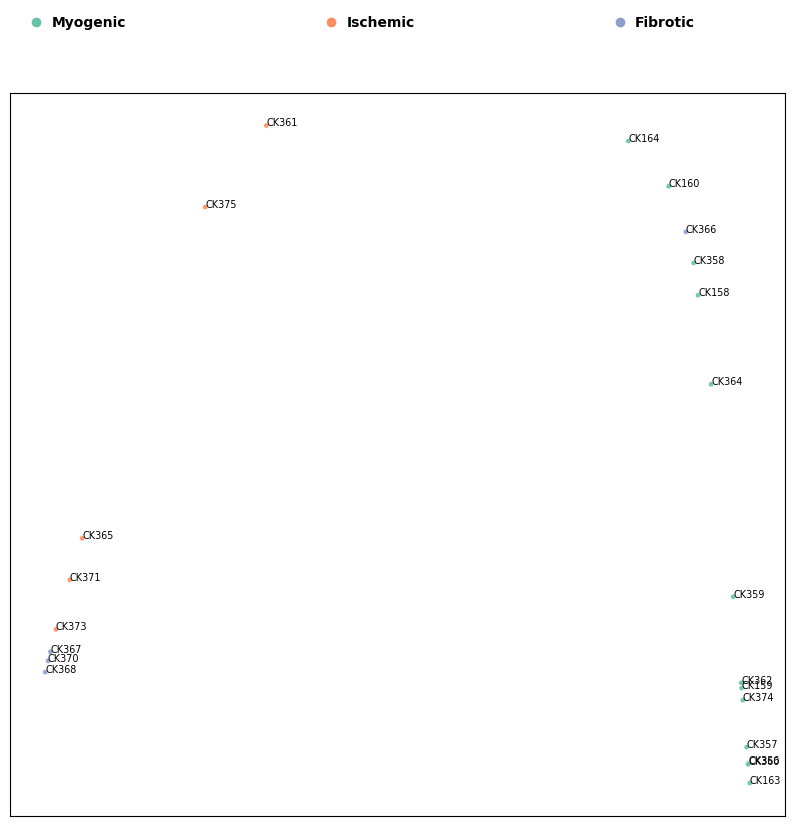

/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (92425770 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (91067436 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (90870576 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93203367 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT

/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial/FNGW_1_4CNP_1_4CCB_1_2RNA_diffusion_projection_high_res_histoslides+withNorm.pdf
/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial/FNGW_1_4CNP_1_4CCB_1_2RNA_diffusion_projection_high_res_nicheslides+withNorm.pdf


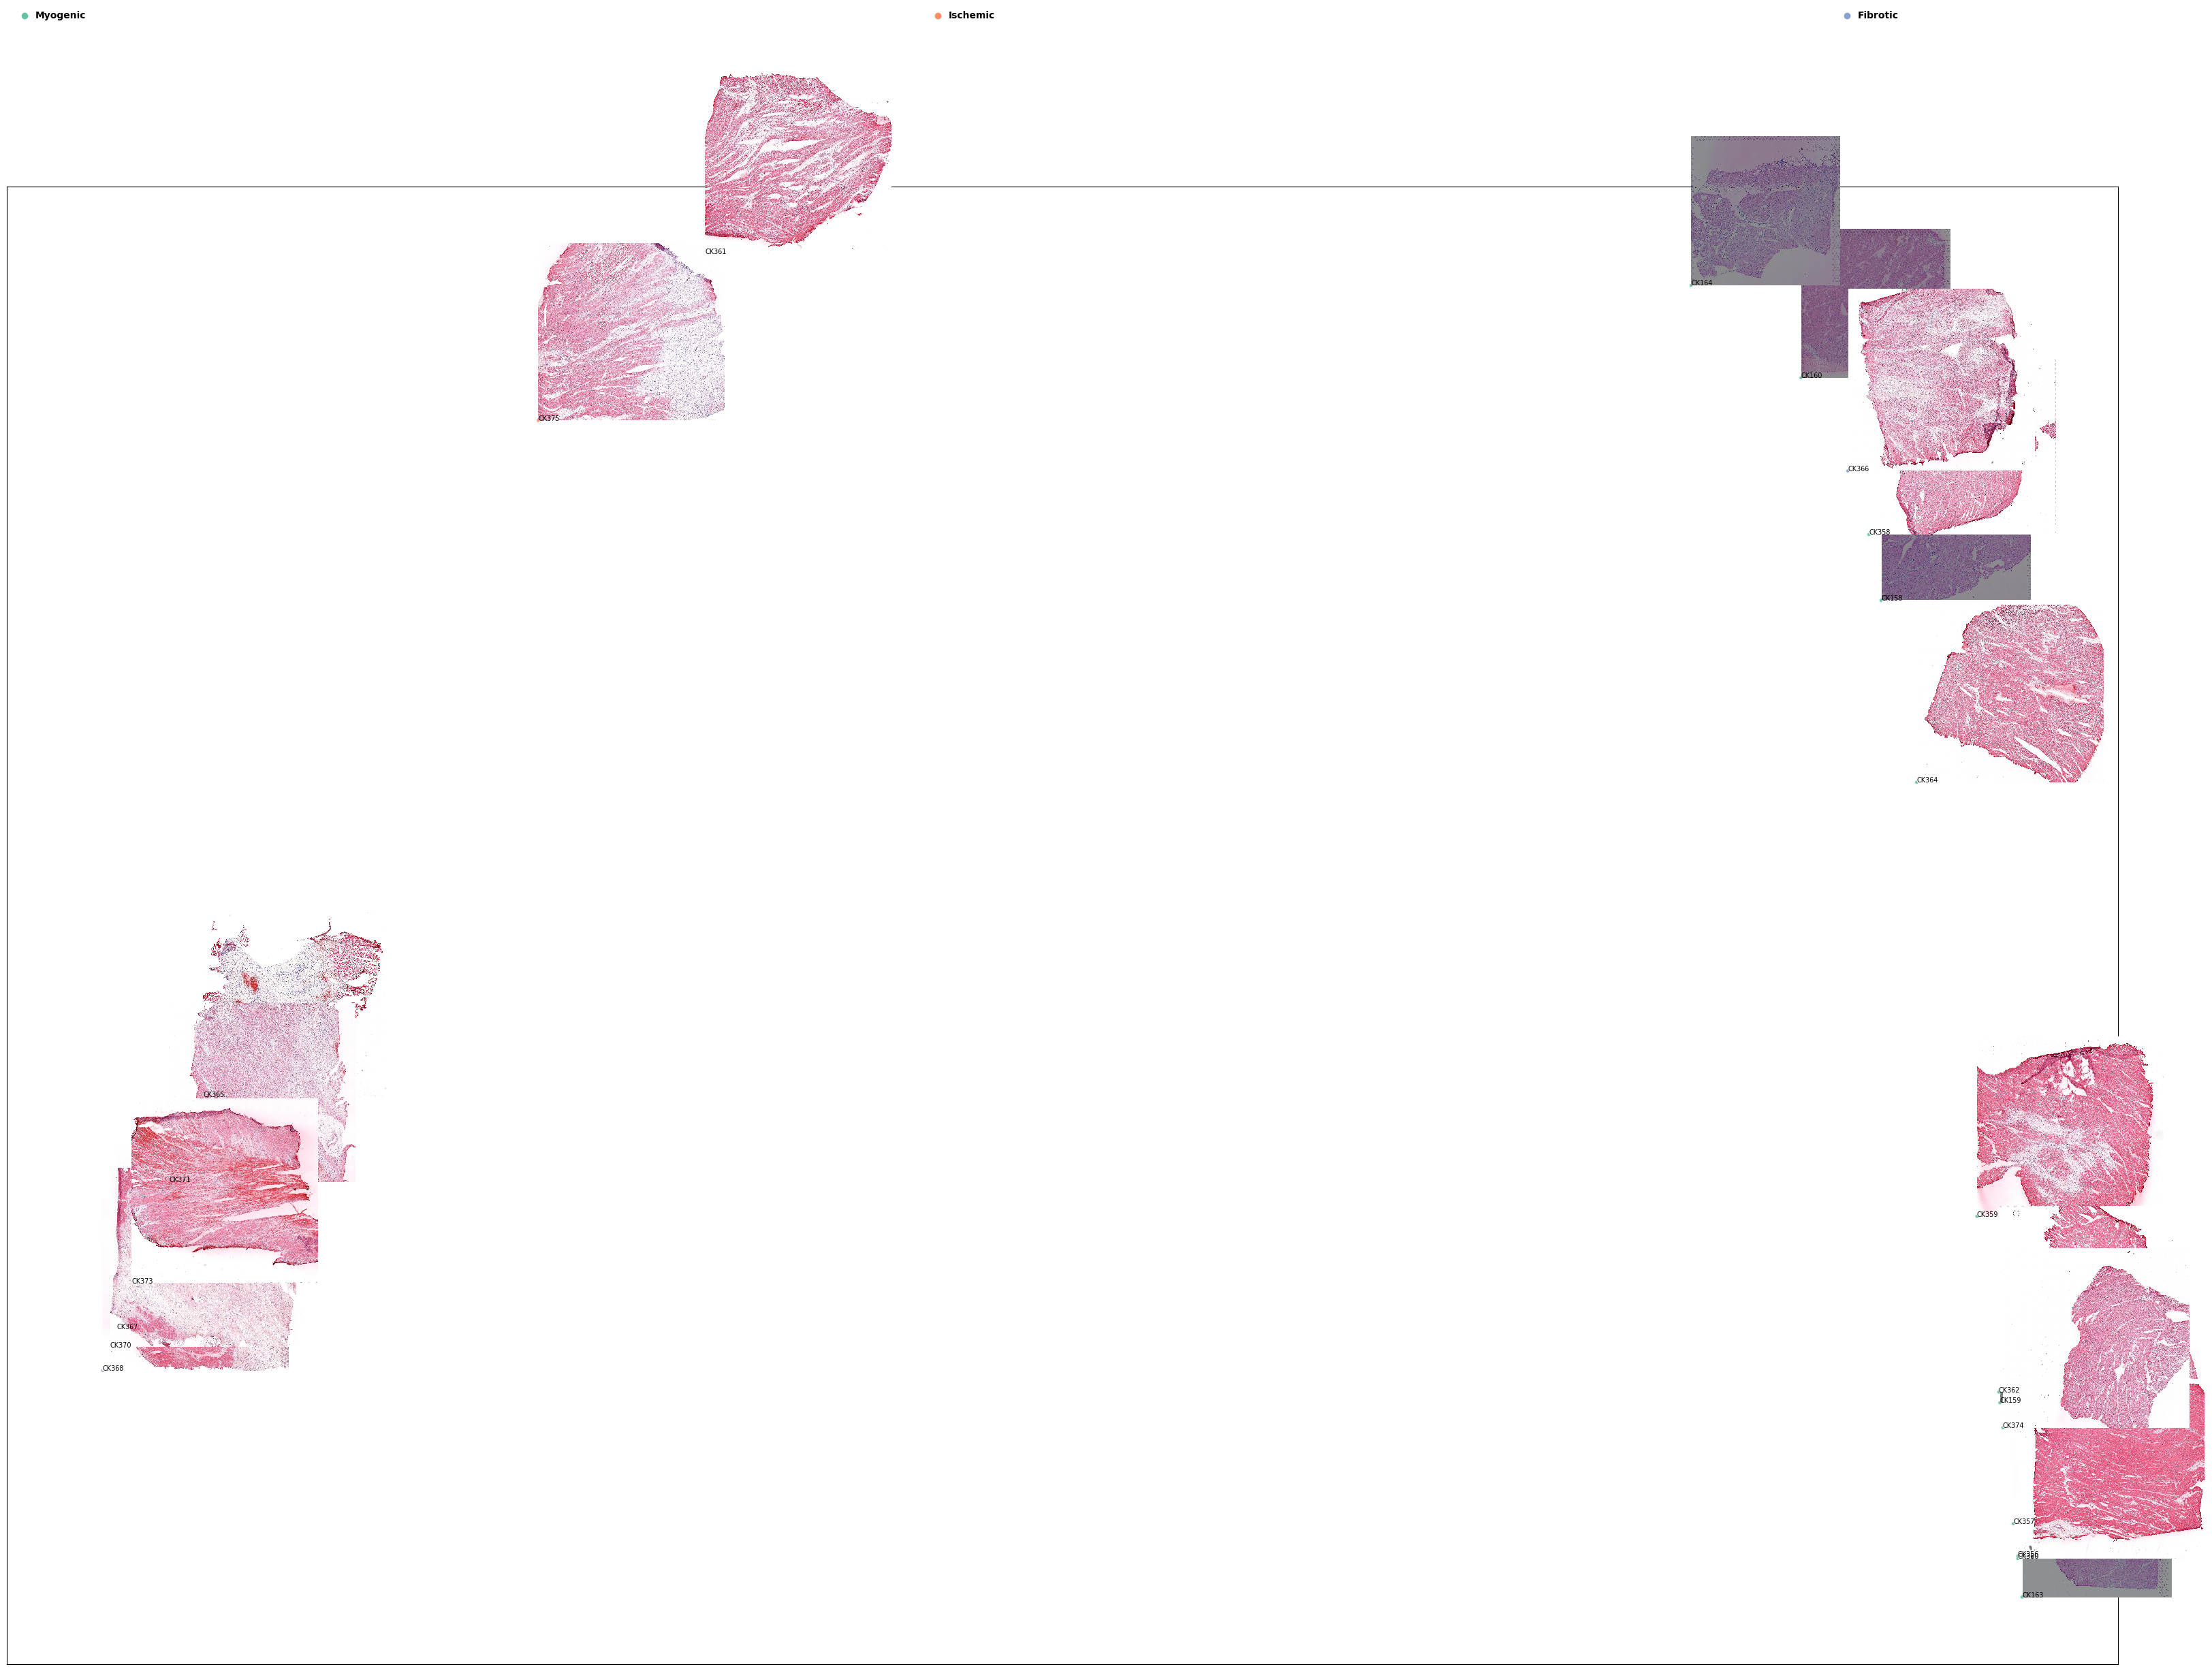

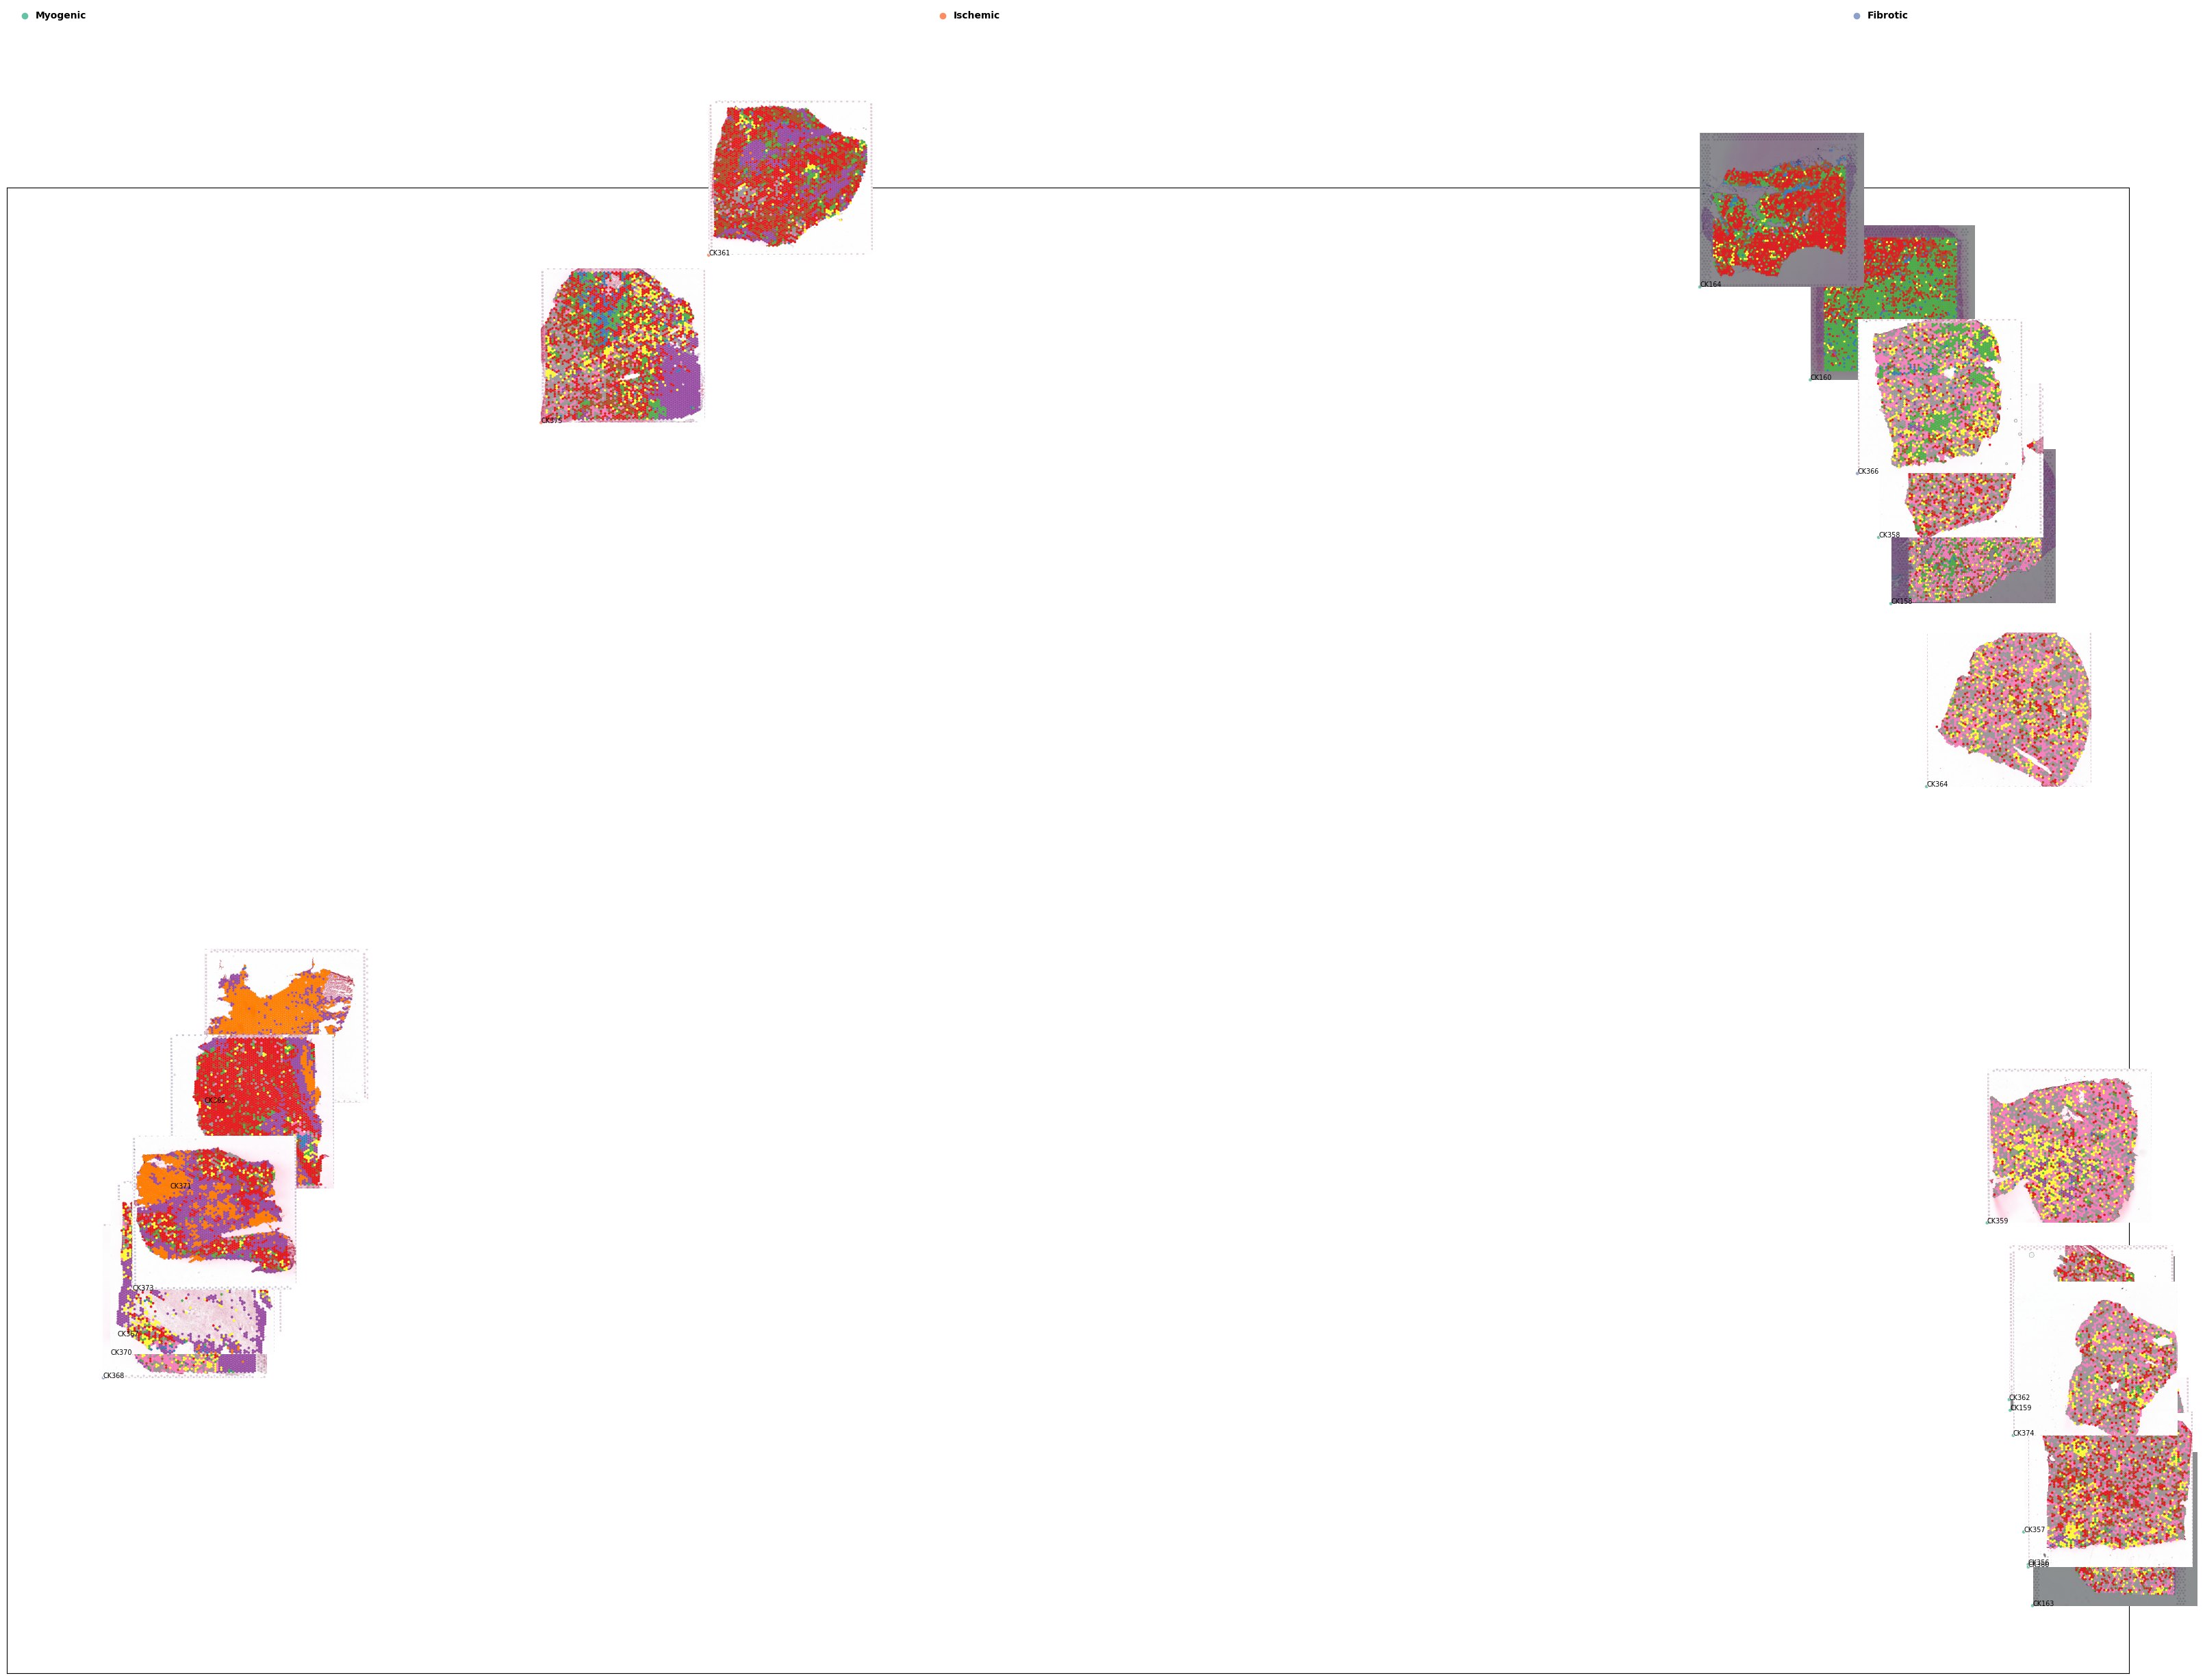

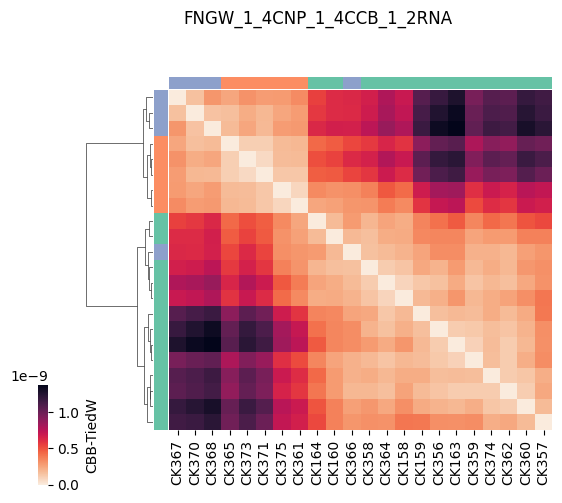

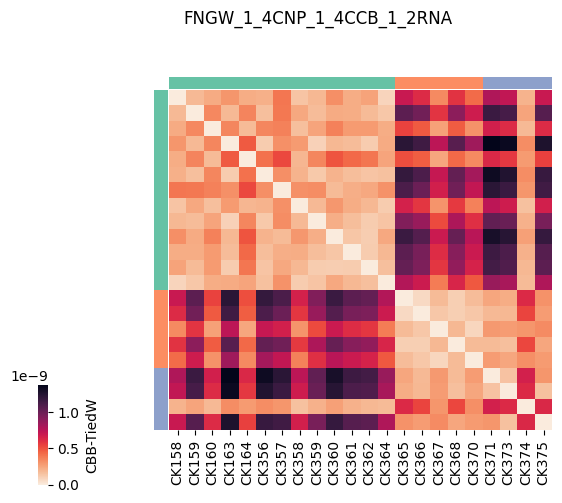

In [ ]:
%load_ext autoreload
%autoreload 2
save_folder = "/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial" 
frames_emb_phate = []
frames_emb_mds = []
frames_dists = []
frames_dists_cluster = []


for m, (method, func) in enumerate(methods.items()):
#if True:
    if "FNGW_1/4CNP_1/4CCB_1/2RNA" in method:
        
        precomputed_dists[method.replace("/","_")] = precomputed_dists[method]
        method = method.replace("/","_")
    #if "CCB-TiedW_a0.40" in method:
#    method="CCB-TiedW"
  # np-array needed for later indexing

        

    #ordered_dists = np.roll(ordered_dists,-200,axis=(0,1))
        dist = precomputed_dists[method]

    #ordered_dists[:800,:800] = precomputed_dists[method][200:,200:] 
    #ordered_dists[800:,:] = precomputed_dists[method][:200,:] 
    #ordered_dists[:,800:] = precomputed_dists[method][:,:200] 
    
        print(method)

    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=True,save_path=f"{save_folder}/log_mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=True,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}_cluster.png",cmap='tab20')

    #colors = sns.color_palette("Paired") #palette=cmap,n_colors=len(unique_labels))
    #cmap_dict = dict(LS=colors[0], RS=colors[1], LR=colors[2], RR=colors[3], DMN=colors[6]) 
        frames_emb_phate.append(f"{save_folder}/{method}_diffusion_projection_high_res.pdf")

        frames_emb_mds.append(f"{save_folder}/{method}_mds_projection.png")
        frames_dists.append(f"{save_folder}/{method}_dists.png")
        frames_dists_cluster.append(f"{save_folder}/{method}_dists_cluster.png")

        plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,save_path=frames_emb_mds[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)

        plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids) 
        plt.show()
        emb = plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_diffusion_projection_high_res_histoslides+withNorm.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_image_paths) #,cmap=cmap_dict)
        plot_emb(dist,precomputed_emb=emb,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_diffusion_projection_high_res_nicheslides+withNorm.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_niches_paths) #,cmap=cmap_dict)
        
        fig = hier_clustering(dist,labels, method="ward", ax=None, cluster=True,title=method,dist_name="CBB-TiedW",log=False,save_path=frames_dists_cluster[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)
        
        
        labels_ = list(map(lambda x: label_order.index(x), labels))  # remark: py3 would work different here
        inds = np.argsort(list(labels_))
        ordered_labels = np.asarray(labels)[inds] #[200:] + labels[:200]
        ordered_dists =  dist[inds,:][:,inds]
        fig = hier_clustering(ordered_dists,ordered_labels, method="ward", ax=None, cluster=False,title=method,dist_name="CBB-TiedW",log=False,save_path=frames_dists[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)
 


In [ ]:
%load_ext autoreload
%autoreload 2

plot_emb(dist,precomputed_emb=emb,method='diffusion',colors=labels,symbols=None,ax=None,s=250,save_path=f"{save_folder}/trajectory/{method}_diffusion_projection_high_res_histoslides.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_image_paths) #,cmap=cmap_dict)
plot_emb(dist,precomputed_emb=emb,method='diffusion',colors=labels,symbols=None,ax=None,s=250,save_path=f"{save_folder}/trajectory/{method}_diffusion_projection_high_res_nicheslides.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_niches_paths) #,cmap=cmap_dict)
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'emb' is not defined

In [ ]:
   
import imageio

# Order of images
#with imageio.get_writer(f"{save_folder}/dists_animation.gif", mode='I') as writer:
#    for filename in frames_dists:
#        image = imageio.imread(filename)
#        writer.append_data(image)


def frames2ani(frames,path,fps=0.01):
    print(frames)
    images = list(map(lambda frame: imageio.imread(frame), frames))

    imageio.mimsave(path, images, duration = len(frames) *1/fps) 

frames2ani(frames_dists,f"{save_folder}/dists_animation.gif")
frames2ani(frames_emb_phate,f"{save_folder}/phate_emb_animation.gif")
frames2ani(frames_emb_mds,f"{save_folder}/mds_emb_animation.gif")
#with imageio.get_writer(f"{save_folder}/emb_animation.gif", mode='I') as writer:
#    for filename in frames_emb:
#        image = imageio.imread(filename)
#        writer.append_data(image)
#images = list(map(lambda filename: imageio.imread(filename), filenames))
#imageio.mimsave(f"{save_folder}/emb_animation.gif", frames_emb, duration = 1) 

['/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial/CCB-TiedW_a0.70_dists.png']


/tmp/ipykernel_1219830/2783819584.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda frame: imageio.imread(frame), frames))


['/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial/CCB-TiedW_a0.70_diffusion_projection_high_res.pdf']


FileNotFoundError: No such file: '/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial/CCB-TiedW_a0.70_diffusion_projection_high_res.pdf'

In [ ]:
singleCell_df = sc.read_h5ad("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/snRNAseq_cellsWithSubtype50000cells.h5ad")

def getCellInds(patient):
    return np.where(singleCell_df.obs["patient_region_id"] == patient)[0]   
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
